In [1]:
TRAIN_ALL = False
TRAIN_BEST = True

In [2]:
from IPython.display import display, Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.utils import class_weight

from keras import initializers, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Flatten, MaxPooling1D, CuDNNLSTM
from keras.models import Sequential, load_model, model_from_json
from keras.utils import plot_model, to_categorical

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import itertools
import keras
import time
import os

Using TensorFlow backend.


## Utilities

In [3]:
def plot_confusion_matrix(cm, class_labels, model_name, cmap=plt.cm.Blues):
    diagram_dir = os.path.join(os.getcwd(), "images")
    if not os.path.exists(diagram_dir):
        os.makedirs(diagram_dir)
    
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)
    
    # create the figure
    fig = plt.figure()
    fig.set_size_inches(12,10)
    
    # labels
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    # tick marks
    class_count = len(class_labels)
    tick_marks = np.arange(class_count + 1)
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # normalization
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, 6)
    cm = np.nan_to_num(cm)
    
    # numbers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
    
    # color bar
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    # save and show
    np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
    plt.savefig(os.path.join(diagram_dir, model_name + "_confusion_matrix.png"), dpi=100)
    pd.DataFrame(cm).to_csv(os.path.join(stats_dir, model_name + "_confusion_matrix.txt"), header=None, index=None)
    plt.show(block=False)
    

def graph_history(history, model_name, validation_data=False):
    directory = os.path.join(os.getcwd(), "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # summarize history for accuracy
    fig = plt.figure()
    plt.plot(history.history["acc"], linestyle="-", color="k")
    
    if validation_data:
        plt.plot(history.history["val_acc"], linestyle="--", color="grey")
        plt.legend(["Tr. Acc", "Val. Acc"])
    
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.savefig(os.path.join(directory, model_name + "_history_accuracy.png"), dpi=400)
    plt.show()
 
    # summarize history for loss
    fig = plt.figure()
    plt.plot(history.history["loss"], linestyle="-", color="k")
    
    if validation_data:
        plt.plot(history.history["val_loss"], linestyle="--", color="grey")
        plt.legend(["Tr. Loss", "Val. Loss"])
    
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.savefig(os.path.join(directory, model_name + "_history_loss.png"), dpi=400)
    plt.show()

    
def save_model(model, model_name):
    directory = os.path.join(os.getcwd(), "models")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # save architecture
    with open(os.path.join(directory, model_name + ".json"), "w+") as f:
        f.write(model.to_json())
    
    # save weights
    model.save_weights(os.path.join(directory, model_name + "_weights.h5"))

def load_model(model_name):
    directory = os.path.join(os.getcwd(), "models")

    if os.path.exists(directory):
        # load the architecture
        json_file = open(os.path.join(directory, model_name + ".json"))
        model = model_from_json(json_file.read())
        model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
        json_file.close()

        # load the weights and return the model
        model.load_weights(os.path.join(directory, model_name + "_weights.h5"))
        return model

## Load data

In [4]:
# how long does this take?
start = time.time()

filename = "C:/Users/David/iCloudDrive/Documents/masters/thesis/data/snapshots/random_snapshots.csv"

# read the file with all dtypes
col_names = pd.read_csv(filename, nrows=0).columns
types_dict = {"Vehicle": int, "Capture": int}
types_dict.update({col: int for col in col_names if col not in types_dict})
df = pd.read_csv(filename, dtype=types_dict)

display(df.sample(frac=0.0001).head(5))
print("Elapsed time: {:.2f} seconds".format(time.time() - start))

,Vehicle,Capture,Data 1,Data 2,Data 3,Data 4,Data 5,Data 6,Data 7,Data 8,...,Data 1015,Data 1016,Data 1017,Data 1018,Data 1019,Data 1020,Data 1021,Data 1022,Data 1023,Data 1024
73144,3,11,128,192,0,0,176,8,217,0,...,0,255,0,36,0,255,0,0,15,1
114740,3,14,0,5,0,46,4,130,42,255,...,0,0,107,8,160,254,0,0,0,5
98159,3,12,0,7,240,34,0,192,28,119,...,152,0,252,0,0,0,207,160,128,0
42351,3,7,0,5,251,7,0,0,3,191,...,51,217,0,1,0,0,16,214,0,7
156288,4,19,160,0,0,128,73,171,86,0,...,0,127,3,0,0,0,0,224,0,1


Elapsed time: 49.78 seconds


In [5]:
# relabel the vehicles
new_labels = {v: i for i, v in enumerate(df["Vehicle"].unique())}
old_labels = {i: v for i, v in enumerate(df["Vehicle"].unique())}

df["Vehicle"] = df["Vehicle"].map(new_labels)
display(df.sample(frac=0.0001).head(5))

,Vehicle,Capture,Data 1,Data 2,Data 3,Data 4,Data 5,Data 6,Data 7,Data 8,...,Data 1015,Data 1016,Data 1017,Data 1018,Data 1019,Data 1020,Data 1021,Data 1022,Data 1023,Data 1024
194641,4,21,0,155,16,0,0,14,228,17,...,0,113,151,1,2,21,0,1,109,1
106439,2,13,7,95,0,0,2,3,2,0,...,84,255,0,0,0,255,255,255,16,34
101713,2,13,0,51,134,0,128,0,0,12,...,255,0,0,0,25,0,0,255,160,0
140393,2,16,0,243,0,187,0,16,66,0,...,0,0,0,0,255,217,217,2,10,255
128484,2,15,0,84,0,0,0,112,55,0,...,0,0,0,0,0,42,1,0,38,2


## Separate the data

In [6]:
"""
All vehicles
"""

# split into (x, y) sets
all_df_x = df.drop(columns=["Vehicle", "Capture"])
all_df_y = df["Vehicle"]

# split vehicles into train/validation/test (60/20/20)
all_nontest_x, all_test_x, all_nontest_y, all_test_y = train_test_split(all_df_x, all_df_y, test_size=0.2)
all_train_x, all_val_x, all_train_y, all_val_y = train_test_split(all_nontest_x, all_nontest_y, test_size=0.25)

# scale the inputs
all_train_x /= 255.
all_val_x /= 255.
all_test_x /= 255.

# encode the labels as one-hot variables
all_train_y = keras.utils.to_categorical(all_train_y, 20)
all_val_y = keras.utils.to_categorical(all_val_y, 20)
all_test_y = keras.utils.to_categorical(all_test_y, 20)

# sanity check
print("Train      : {} {}".format(all_train_x.shape, all_train_y.shape))
print("Validation : {} {}".format(all_val_x.shape, all_val_y.shape))
print("Test       : {} {}".format(all_test_x.shape, all_test_y.shape))

Train      : (179229, 1024) (179229, 20)
Validation : (59743, 1024) (59743, 20)
Test       : (59743, 1024) (59743, 20)


In [7]:
"""
All vehicles balanced
"""

# balance the dataset
min_size = np.min([len(df[df["Vehicle"] == i]) for i in df["Vehicle"].unique()])
balanced_df = df.groupby("Vehicle", group_keys=False).apply(pd.DataFrame.sample, n=min_size)

# split into (x, y) sets
balanced_df_x = balanced_df.drop(columns=["Vehicle", "Capture"])
balanced_df_y = balanced_df["Vehicle"]

# split vehicles into train/validation/test (60/20/20)
balanced_nontest_x, balanced_test_x, balanced_nontest_y, balanced_test_y = train_test_split(balanced_df_x, balanced_df_y, test_size=0.2)
balanced_train_x, balanced_val_x, balanced_train_y, balanced_val_y = train_test_split(balanced_nontest_x, balanced_nontest_y, test_size=0.25)

# scale the inputs
balanced_train_x /= 255.
balanced_val_x /= 255.
balanced_test_x /= 255.

# encode the labels as one-hot variables
balanced_train_y = keras.utils.to_categorical(balanced_train_y, 20)
balanced_val_y = keras.utils.to_categorical(balanced_val_y, 20)
balanced_test_y = keras.utils.to_categorical(balanced_test_y, 20)

# sanity check
print("Train      : {} {}".format(balanced_train_x.shape, balanced_train_y.shape))
print("Validation : {} {}".format(balanced_val_x.shape, balanced_val_y.shape))
print("Test       : {} {}".format(balanced_test_x.shape, balanced_test_y.shape))

Train      : (20508, 1024) (20508, 20)
Validation : (6836, 1024) (6836, 20)
Test       : (6836, 1024) (6836, 20)


In [8]:
"""
Only Stone's vehicles
"""

# split into (x, y) sets
stone = df[df["Vehicle"] >= 9]
stone_x = stone.drop(columns=["Vehicle", "Capture"])
stone_y = stone["Vehicle"] - 9

# split vehicles into train/validation/test (60/20/20)
stone_nontest_x, stone_test_x, stone_nontest_y, stone_test_y = train_test_split(stone_x, stone_y, test_size=0.2)
stone_train_x, stone_val_x, stone_train_y, stone_val_y = train_test_split(stone_nontest_x, stone_nontest_y, test_size=0.25)

# scale the inputs
stone_train_x /= 255.
stone_val_x /= 255.
stone_test_x /= 255.

# encode the labels as one-hot variables
stone_train_y = keras.utils.to_categorical(stone_train_y, 11)
stone_val_y = keras.utils.to_categorical(stone_val_y, 11)
stone_test_y = keras.utils.to_categorical(stone_test_y, 11)

# sanity check
print("Train      : {} {}".format(stone_train_x.shape, stone_train_y.shape))
print("Validation : {} {}".format(stone_val_x.shape, stone_val_y.shape))
print("Test       : {} {}".format(stone_test_x.shape, stone_test_y.shape))

Train      : (17055, 1024) (17055, 11)
Validation : (5685, 1024) (5685, 11)
Test       : (5685, 1024) (5685, 11)


In [9]:
"""
Stone's vehicles balanced
"""

# balance the dataset
stone_min_size = np.min([len(stone[stone["Vehicle"] == i]) for i in stone["Vehicle"].unique()])
stone_balanced_df = stone.groupby("Vehicle", group_keys=False).apply(pd.DataFrame.sample, n=stone_min_size)

# split into (x, y) sets
stone_balanced_df_x = balanced_df.drop(columns=["Vehicle", "Capture"])
stone_balanced_df_y = balanced_df["Vehicle"] - 9

# split vehicles into train/validation/test (60/20/20)
stone_balanced_nontest_x, stone_balanced_test_x, stone_balanced_nontest_y, stone_balanced_test_y \
    = train_test_split(stone_balanced_df_x, stone_balanced_df_y, test_size=0.2)
stone_balanced_train_x, stone_balanced_val_x, stone_balanced_train_y, stone_balanced_val_y \
    = train_test_split(stone_balanced_nontest_x, stone_balanced_nontest_y, test_size=0.25)

# scale the inputs
stone_balanced_train_x /= 255.
stone_balanced_val_x /= 255.
stone_balanced_test_x /= 255.

# encode the labels as one-hot variables
stone_balanced_train_y = keras.utils.to_categorical(stone_balanced_train_y, 11)
stone_balanced_val_y = keras.utils.to_categorical(stone_balanced_val_y, 11)
stone_balanced_test_y = keras.utils.to_categorical(stone_balanced_test_y, 11)

# sanity check
print("Train      : {} {}".format(stone_balanced_train_x.shape, stone_balanced_train_y.shape))
print("Validation : {} {}".format(stone_balanced_val_x.shape, stone_balanced_val_y.shape))
print("Test       : {} {}".format(stone_balanced_test_x.shape, stone_balanced_test_y.shape))

Train      : (20508, 1024) (20508, 11)
Validation : (6836, 1024) (6836, 11)
Test       : (6836, 1024) (6836, 11)


## Build the models

In [10]:
def build_model(hidden_layers, hidden_layer_width, activation, learning_rate, filename):
    directory = os.path.join(os.getcwd(), "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    model = Sequential()
    
    # build the first hidden layer
    model.add(Dense(
        units = hidden_layer_width,
        input_dim = 1024,
        activation = activation,
        use_bias = True,
        bias_initializer = initializers.Constant(0.1) if activation == "relu" else "zeros"))
    
    # build the remaining hidden layers
    for i in range(hidden_layers - 1):
        model.add(Dense(
            units = hidden_layer_width, 
            activation = activation, 
            use_bias = True, 
            bias_initializer = initializers.Constant(0.1) if activation == "relu" else "zeros"))
    
    # add some regularization
    model.add(Dropout(0.2))
    
    # build the output layer
    model.add(Dense(
        units = 11, 
        activation = "softmax", 
        use_bias = True, 
        bias_initializer = "zeros"))
    
    # compile the model
    model.compile(
        optimizer = optimizers.Adam(lr=learning_rate),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"])

    # display and return the model
    print(model.summary())
    filename = os.path.join(directory, filename + "_diagram.png")
    plot_model(model, show_shapes=True, show_layer_names=True, to_file=filename)
    display(Image(filename=filename, width=400))
    
    return model

In [11]:
# model configurations
num_hidden_layers = [1, 2, 3]
hidden_layer_widths = [128, 256, 512]
activation_functions = ["relu"]
learning_rates = [0.01, 0.001, 0.0001]

## Train and test all models

In [12]:
if TRAIN_ALL:
    # how long does this take?
    start_time = time.time()
    
    # we'll need these
    train_x = stone_train_x
    train_y = stone_train_y
    val_x = stone_val_x
    val_y = stone_val_y
    test_x = stone_test_x
    test_y = stone_test_y

    # gather training stats
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)

    stats_path = os.path.join(stats_dir, "training_stats.csv")
    stats_file = open(stats_path, "w+")
    stats_file.write(
        "Model,Parameters,Training Epoch,Training Loss,Training Accuracy,Test Loss,Test Accuracy,Balanced Test Accuracy\n")

    # gather model stats
    models_dir = os.path.join(os.getcwd(), "models")
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    models_path = os.path.join(models_dir, "models.csv")
    models_file = open(models_path, "w+")
    models_file.write("Model,Num Layers,Layer Sizes,Activation,Learning Rate\n")

    # stop early if possible
    callbacks = [EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True
    )]

    # this'll take a while
    count = 0
    for n in num_hidden_layers:
        for w in hidden_layer_widths:
            for a in activation_functions:
                for l in learning_rates:
                    print("{}\n{} Model {}: num layers = {}, layer size = {}, activation = {}, learning rate = {}\n{}".format(
                        "=" * 100, "=" * 5, count, n, w, a, l, "=" * 100))

                    # filepaths
                    model_name = "model_{}".format(count)

                    # build and show model
                    model = build_model(n, w, a, l, model_name)

                    # we'll need these
                    y_ints = [y.argmax() for y in train_y]
                    class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)

                    # train model
                    history = model.fit(
                        train_x, train_y,
                        validation_data = (val_x, val_y),
                        class_weight = class_weights,
                        batch_size = 512,
                        epochs = 200,
                        shuffle = True,
                        verbose = 1,
                        callbacks = callbacks)

                    # save trained model
                    # save_model(model, model_name)

                    # show the graph history
                    graph_history(history, model_name, validation_data=True)

                    # evaluate the model
                    evaluation = model.evaluate(test_x, test_y, verbose=0)

                    print("--- Test set evaluation ---")
                    print("Loss              : {:.4f}".format(evaluation[0]))
                    print("Accuracy          : {:.4f}".format(evaluation[1]))

                    # predict the test set and save the labels
                    actual_labels = np.argmax(test_y, axis=1)
                    predicted_labels = np.argmax(model.predict(test_x), axis=1)
                    balanced_acc = balanced_accuracy_score(actual_labels, predicted_labels)

                    print("Balanced accuracy : {:.4f}".format(balanced_acc))

                    # revert to the original vehicle IDs
                    actual_labels = [old_labels[i] for i in actual_labels]
                    predicted_labels = [old_labels[i] for i in predicted_labels]

                    # generate, save, and display confusion matrix
                    cm = confusion_matrix(predicted_labels, actual_labels)
                    plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

                    # get stats
                    params = model.count_params()
                    best_epoch = np.argmin(history.history["val_loss"])
                    best_loss = history.history["val_loss"][best_epoch]
                    best_acc = history.history["val_acc"][best_epoch]

                    # save stats
                    stats = [count, params, best_epoch, best_loss, best_acc, evaluation[0], evaluation[1], balanced_acc]
                    stats_file.write(",".join([str(s) for s in stats]) + "\n")

                    # save model metadata
                    model_metadata = [count, n, w, a, l]
                    models_file.write(",".join([str(d) for d in model_metadata]) + "\n")

                    # next model
                    count += 1

    stats_file.close()
    models_file.close()

    elapsed_time = time.time() - start_time
    print("Elapsed time: {:.2f} seconds ({:.2f} hours)".format(elapsed_time, elapsed_time / 3600.))

## Train and test the best model

W0923 11:20:13.994491  9416 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Model              21
Num Layers          3
Layer Sizes       256
Activation       relu
Learning Rate    0.01
Name: 21, dtype: object


W0923 11:20:14.243154  9416 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:519: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 11:20:14.297011  9416 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:4140: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 11:20:14.509442  9416 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0923 11:20:14.557316  9416 deprecation.py:506] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:3447: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 11)                2827      
Total params: 396,811
Trainable params: 396,811
Non-trainable params: 0
_________________________________________________________________
None


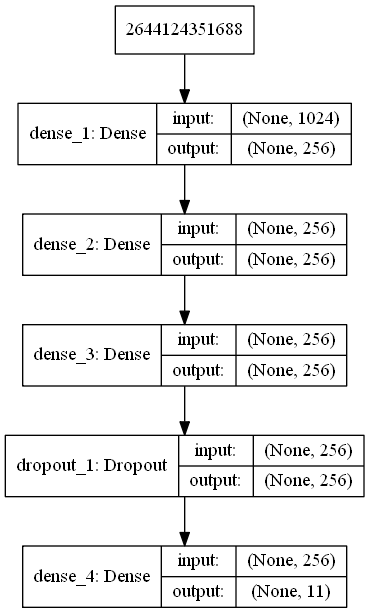

W0923 11:20:17.371788  9416 deprecation.py:323] From C:\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/17
27344/27344 [==============================] - 11s 385us/step - loss: 2.5472 - acc: 0.1282
Epoch 2/17
27344/27344 [==============================] - 2s 60us/step - loss: 2.0366 - acc: 0.2333
Epoch 3/17
27344/27344 [==============================] - 2s 63us/step - loss: 1.7166 - acc: 0.3220
Epoch 4/17
27344/27344 [==============================] - 2s 63us/step - loss: 1.6135 - acc: 0.3475
Epoch 5/17
27344/27344 [==============================] - 2s 68us/step - loss: 1.5120 - acc: 0.3802
Epoch 6/17
27344/27344 [==============================] - 3s 128us/step - loss: 1.4612 - acc: 0.3928
Epoch 7/17
27344/27344 [==============================] - 4s 136us/step - loss: 1.4469 - acc: 0.3966
Epoch 8/17
27344/27344 [==============================] - 4s 143us/step - loss: 1.4380 - acc: 0.3969
Epoch 9/17
27344/27344 [==============================] - 4s 144us/step - loss: 1.4017 - acc: 0.4086
Epoch 10/17
27344/27344 [==============================] - 5s 169us/step - loss: 1.3920 - acc:

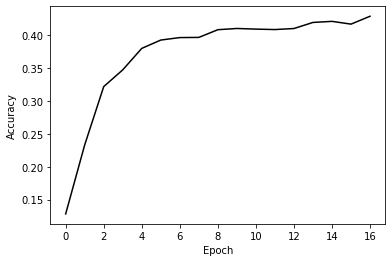

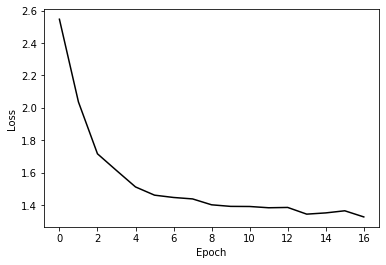

--- Test set evaluation ---
Loss              : 1.3398
Accuracy          : 0.4312
Balanced accuracy : 0.4204


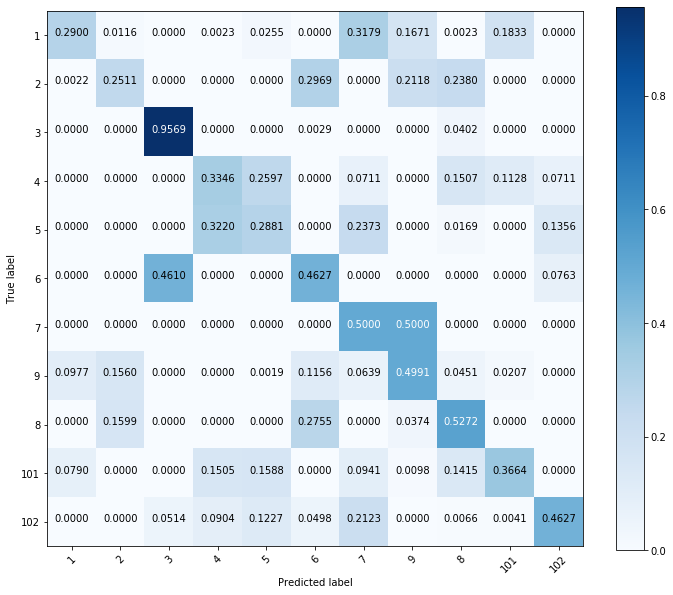

In [13]:
if TRAIN_BEST:
#     for dataset in ["all", "balanced"]:
#     for dataset in ["all"]:
    for dataset in ["balanced"]:
        # best model
        training_stats = pd.read_csv(os.path.join(os.getcwd(), "stats", "training_stats.csv"))
        best_model = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Model"])
        best_epoch = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Training Epoch"])
        
        # model parameters
        model_params = pd.read_csv(os.path.join(os.getcwd(), "models", "models.csv"))
        best_model = model_params.iloc[best_model]
        print(best_model)

        # filepaths
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"

        # build and show model
        model = build_model(best_model["Num Layers"], best_model["Layer Sizes"],
            best_model["Activation"], best_model["Learning Rate"], model_name)

        # we'll need these
        train_x = stone_train_x if dataset == "all" else stone_balanced_train_x
        train_y = stone_train_y if dataset == "all" else stone_balanced_train_y
        val_x = stone_val_x if dataset == "all" else stone_balanced_val_x
        val_y = stone_val_y if dataset == "all" else stone_balanced_val_y
        test_x = stone_test_x if dataset == "all" else stone_balanced_test_x
        test_y = stone_test_y if dataset == "all" else stone_balanced_test_y

        # and these
        y_ints = [y.argmax() for y in train_y]
        class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)
        class_weights = class_weights if dataset == "all" else None

        # train model
        history = model.fit(
            np.concatenate((train_x, val_x)), np.concatenate((train_y, val_y)),
            class_weight = class_weights,
            batch_size = 512,
            epochs = best_epoch,
            shuffle = True,
            verbose = 1)

        # save trained model
        save_model(model, model_name)

        # show the graph history
        graph_history(history, model_name)

        # evaluate the model
        evaluation = model.evaluate(test_x, test_y, verbose=0)

        print("--- Test set evaluation ---")
        print("Loss              : {:.4f}".format(evaluation[0]))
        print("Accuracy          : {:.4f}".format(evaluation[1]))

        # predict the test set and save the labels
        actual_labels = np.argmax(test_y, axis=1)
        predicted_labels = np.argmax(model.predict(test_x), axis=1)

        print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

        # revert to the original vehicle IDs
        actual_labels = [old_labels[i] for i in actual_labels]
        predicted_labels = [old_labels[i] for i in predicted_labels]

        # generate, save, and display confusion matrix
        cm = confusion_matrix(predicted_labels, actual_labels)
        plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

## Load and test the best model

--- Test set evaluation all ---
Loss              : 0.8406
Accuracy          : 0.6259
Balanced accuracy : 0.5926


C:\Anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


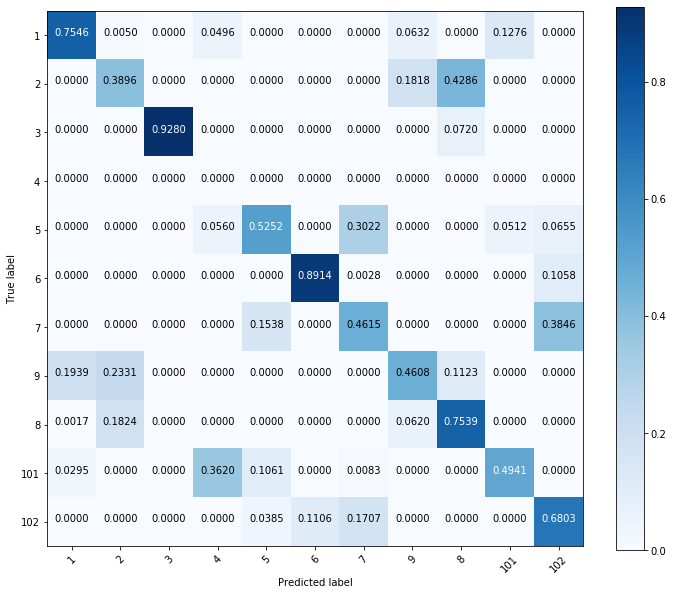

--- Test set evaluation balanced ---
Loss              : 1.3398
Accuracy          : 0.4312
Balanced accuracy : 0.4204


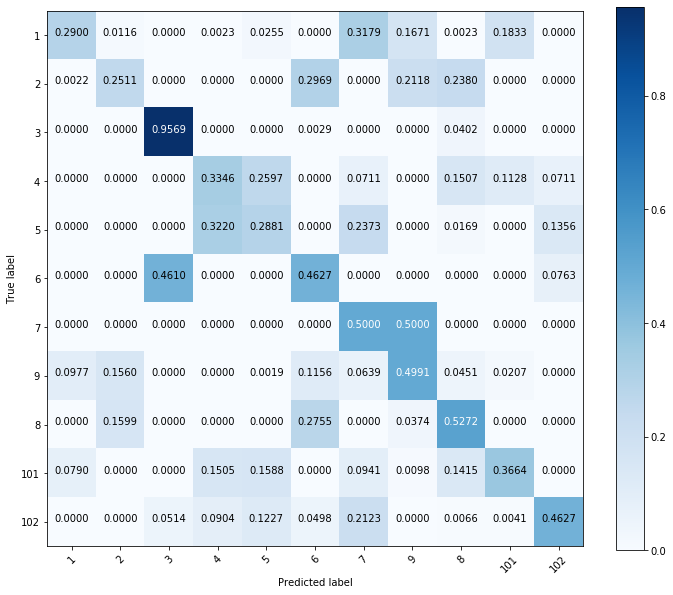

In [14]:
if TRAIN_BEST:
    for dataset in ["all", "balanced"]:
        # we'll need these
        test_x = stone_test_x if dataset == "all" else stone_balanced_test_x
        test_y = stone_test_y if dataset == "all" else stone_balanced_test_y

        # name the model
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"
        model = load_model(model_name)

        # evaluate the model
        evaluation = model.evaluate(test_x, test_y, verbose=0)

        print("--- Test set evaluation {} ---".format(dataset))
        print("Loss              : {:.4f}".format(evaluation[0]))
        print("Accuracy          : {:.4f}".format(evaluation[1]))

        # predict the test set and save the labels
        actual_labels = np.argmax(test_y, axis=1)
        predicted_labels = np.argmax(model.predict(test_x), axis=1)

        print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

        # revert to the original vehicle IDs
        actual_labels = [old_labels[i] for i in actual_labels]
        predicted_labels = [old_labels[i] for i in predicted_labels]

        # generate, save, and display confusion matrix
        cm = confusion_matrix(predicted_labels, actual_labels)
        plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)